In [1]:
!pip install tensorflowjs

In [2]:
%tensorflow_version 1.x
import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

TensorFlow 1.x selected.
• Using TensorFlow Version: 1.15.2


In [3]:

!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-05-25 05:43:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 142.250.99.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   165MB/s    in 0.4s    

2021-05-25 05:43:10 (165 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.843.jpg', 'cat.254.jpg', 'cat.546.jpg', 'cat.201.jpg', 'cat.597.jpg', 'cat.10.jpg', 'cat.277.jpg', 'cat.644.jpg', 'cat.27.jpg', 'cat.446.jpg']
['dog.514.jpg', 'dog.622.jpg', 'dog.570.jpg', 'dog.629.jpg', 'dog.167.jpg', 'dog.791.jpg', 'dog.831.jpg', 'dog.373.jpg', 'dog.790.jpg', 'dog.670.jpg']


In [7]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [9]:

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

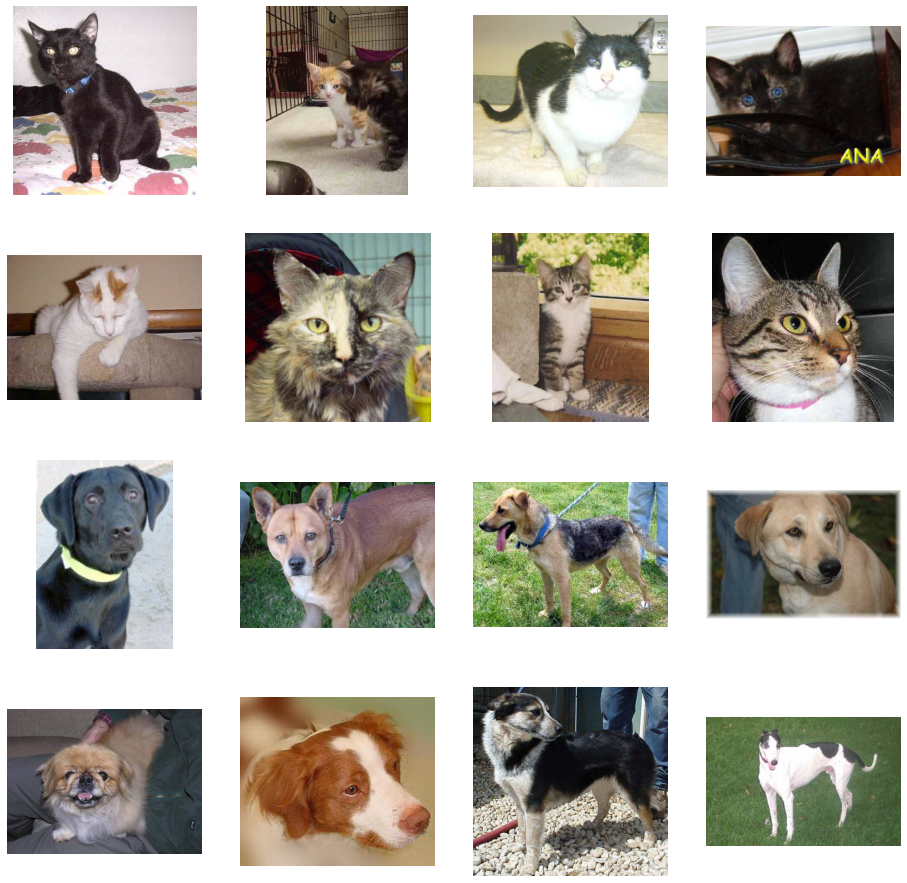

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
Epoch 1/15
100/100 - 15s - loss: 0.7625 - acc: 0.5385 - val_loss: 0.7603 - val_acc: 0.5150
Epoch 2/15
Epoch 1/15
100/100 - 8s - loss: 0.6590 - acc: 0.6340 - val_loss: 0.6017 - val_acc: 0.6860
Epoch 3/15
Epoch 1/15
100/100 - 8s - loss: 0.5561 - acc: 0.7130 - val_loss: 0.6084 - val_acc: 0.6640
Epoch 4/15
Epoch 1/15
100/100 - 8s - loss: 0.4685 - acc: 0.7800 - val_loss: 0.5821 - val_acc: 0.6840
Epoch 5/15
Epoch 1/15
100/100 - 8s - loss: 0.3925 - acc: 0.8270 - val_loss: 0.5659 - val_acc: 0.7290
Epoch 6/15
Epoch 1/15
100/100 - 8s - loss: 0.2941 - acc: 0.8780 - val_loss: 0.6592 - val_acc: 0.7170
Epoch 7/15
Epoch 1/15
100/100 - 8s - loss: 0.2071 - acc: 0.9165 - val_loss: 0.8376 - val_acc: 0.7130
Epoch 8/15
Epoch 1/15
100/100 - 8s - loss: 0.1424 - acc: 0.9470 - val_loss: 0.9206 - val_acc: 0.7420
Epoch 9/15
Epoch 1/15
100/100 - 8s - loss: 0.0937 - acc: 0.9700 - val_loss: 1.0782 - val_acc: 0.7310
Epoch 10/15
Epoch 1/15
100/100 - 8s - loss: 0.0800 - acc: 0.9745 - val_loss: 1.0832 - val_

Text(0.5, 1.0, 'Training and validation loss')

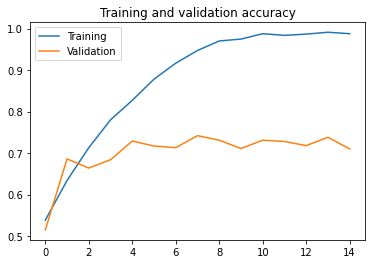

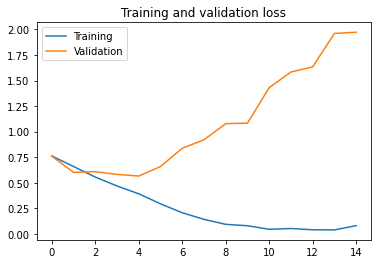

In [18]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[ 'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

In [19]:

# EXERCISE: Save the trained model as a Keras HDF5 file. 

saved_model_path = "./my_model.h5"

model.save(saved_model_path)

In [20]:
! tensorflowjs_converter \
    --input_format=keras \
    {saved_model_path} \
    "./"